# ABALONE AGE PREDICTION

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bc/Abalone_at_California_Academy_of_Sciences.JPG" width=400>


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Load train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
train_df.shape

(90615, 10)

In [6]:
test_df.shape

(60411, 9)

In [7]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [8]:
duplicates_row = train_df.duplicated().sum()
print('Number of duplicated rows:', duplicates_row)

Number of duplicated rows: 0


<Axes: xlabel='Rings', ylabel='count'>

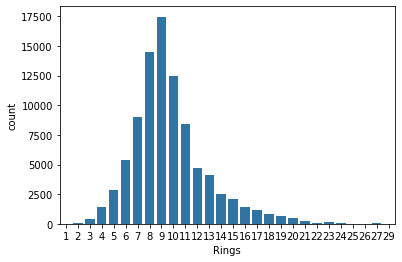

In [9]:
# Visualize the distribution of the target variable (Rings)

sns.countplot(x='Rings', data=train_df)

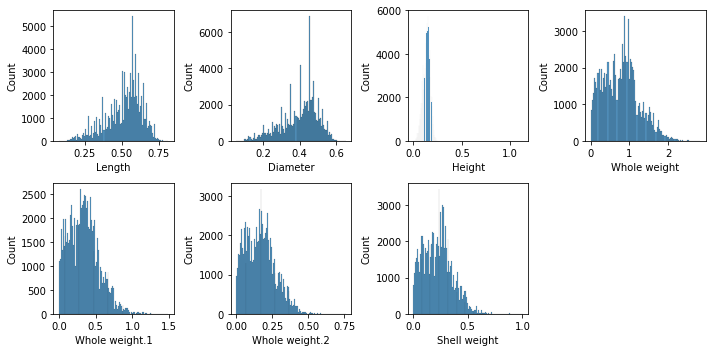

In [10]:
# Visualize the distribution of the variable 

cols = train_df.drop(['id', 'Rings', 'Sex'], axis=1).columns

plt.figure(figsize=(10,5))
for i, col in enumerate(cols):
    plt.subplot(2, 4, i + 1)
    sns.histplot(x=col, data= train_df)
    plt.tight_layout()
plt.show()

In [11]:
# Encode categorical variables

le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])

In [12]:
# # Adding new features
# def new_features(df):
#     df['top surface area'] = np.pi * (df['Diameter'] / 2) ** 2
#     df['Water Loss'] = df['Whole weight'] - (df['Whole weight.1'] + df['Whole weight.2'] + df['Shell weight'])
# #     df['Length/Diameter'] = df['Length'] / df['Diameter']
# #     df['Length/Height'] = df['Length'] / df['Height']
# #     df['Diameter/Height'] = df['Diameter'] / df['Height']
#     df['Volume'] = np.pi * (df['Diameter'] / 2) ** 2 * df['Height']
# #    df['Abalone Density'] = df['Whole weight'] / df['Volume']
#     df['BMI'] = df['Whole weight'] / (df['Length'] ** 2)

In [13]:
# new_features(train_df)
# new_features(test_df)

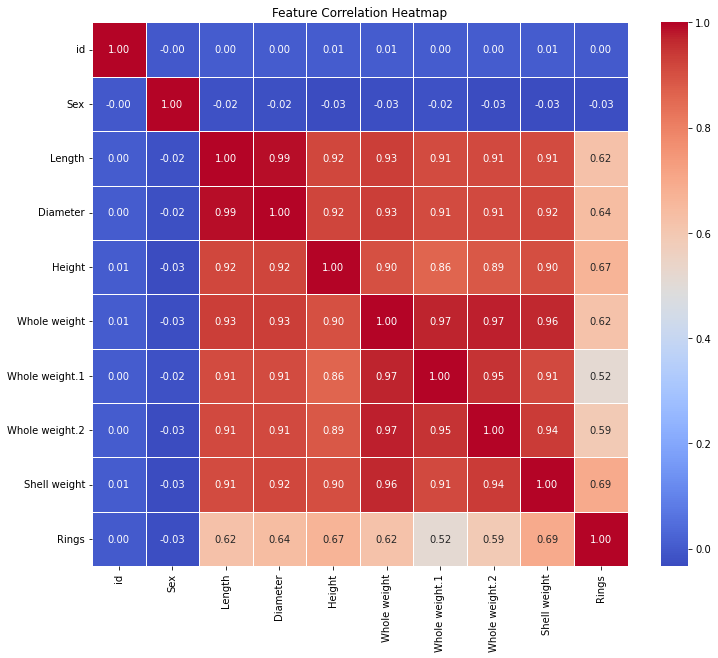

In [14]:
# Calculate the correlation matrix
corr = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [15]:
X = train_df.drop(['id', 'Rings'], axis=1)
y = train_df['Rings']
X_test = test_df.drop('id', axis=1)

In [16]:
# X = (X - X.mean()) / np.std(X)
# X_test = (X_test - X_test.mean()) / np.std(X_test)

In [17]:
# Split data into train and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define custom RMSLE scorer: (Root Mean Squared Logarithmic Error)
def rmsle_score(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    squared_log_errors = (np.log1p(y_pred) - np.log1p(y_true)) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    rmsle = np.sqrt(mean_squared_log_error)
    return rmsle

In [19]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [20]:
# Define models

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(),
    SVR(),
    XGBRegressor(),
    CatBoostRegressor(verbose=0),
    LGBMRegressor()
]

In [21]:
# Track best model and its RMSLE score

best_model = None
best_model_name = ""
best_rmsle = float('inf')

# Lists to store model names and their corresponding RMSLE values
model_names = []
rmsle_values = []

# Evalute models
for model in models:
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate RMSLE score
    rmsle = rmsle_score(y_test, y_pred)
    
    # Print RSMLE score
    print(f'{model.__class__.__name__}: RMSLE: {rmsle}')
    
    # Store the model name and RMSLE value
    model_names.append(model.__class__.__name__)
    rmsle_values.append(rmsle)
    
    if rmsle < best_rmsle:
        best_model = model
        best_model_name = model.__class__.__name__
        best_rmsle = rmsle
        
print(f'Best model: {best_model_name}')

LinearRegression: RMSLE: 0.16788369061299604
DecisionTreeRegressor: RMSLE: 0.2168817904247891
RandomForestRegressor: RMSLE: 0.1559158972567478
GradientBoostingRegressor: RMSLE: 0.15567550418547635
SVR: RMSLE: 0.15893590278683445
XGBRegressor: RMSLE: 0.15192754235811698
CatBoostRegressor: RMSLE: 0.15128924362291235
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 9.697111
LGBMRegressor: RMSLE: 0.15277213467670908
Best model: CatBoostRegressor


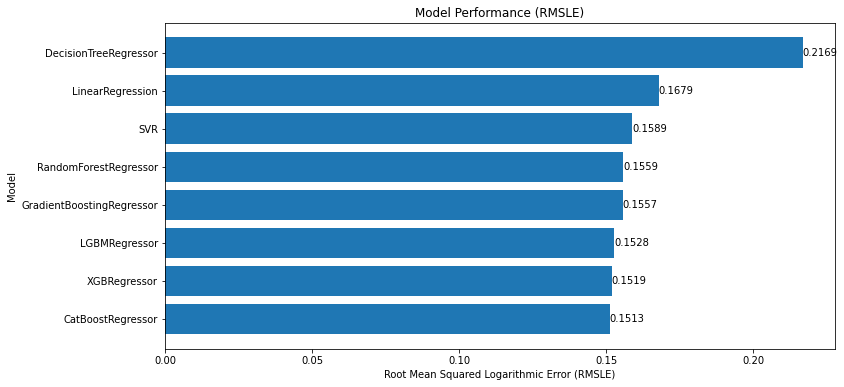

In [22]:
# Plotting the performance
sorted_indices = np.argsort(rmsle_values)
sorted_model_names = np.array(model_names)[sorted_indices]
sorted_rmsle_values = np.array(rmsle_values)[sorted_indices]
plt.figure(figsize=(12, 6))
bars = plt.barh(sorted_model_names, sorted_rmsle_values)
plt.xlabel('Root Mean Squared Logarithmic Error (RMSLE)')
plt.ylabel('Model')
plt.title('Model Performance (RMSLE)')
for bar in bars:
    plt.text(
        bar.get_width(), 
        bar.get_y() + bar.get_height() / 2, 
        f'{bar.get_width():.4f}', 
        va='center'
    )
plt.show()

In [23]:
# Tarin the best pperforming model on full data
best_model.fit(X, y)

In [24]:
# Prediction
predictions = best_model.predict(test_df)
len(predictions)

60411

In [25]:
submission_df = pd.DataFrame({'id': test_df['id'], 'Rings': predictions})
submission_df.to_csv('submission.csv', index=False)
